In [1]:
print("all ok")

all ok


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\MY_Folder\LLMOPS_GIT_Projects\LIVE_LLMOPS\automated-research-report-generation


In [3]:
from dotenv import load_dotenv
from research_and_analyst.utils.model_loader import ModelLoader
model_loader = ModelLoader()

{"timestamp": "2025-10-20T14:17:04.699201Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-20T14:17:04.700329Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-20T14:17:04.701287Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-20T14:17:04.702008Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-20T14:17:04.702895Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-20T14:17:04.703880Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-20T14:17:04.716542Z", "level": "info", "event": "YAML config loaded"}


In [4]:
llm = model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-20T14:17:04.724600Z", "level": "info", "event": "Loading LLM"}


In [5]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [6]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

### health

- `Analyst-1`


Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

- `Analyst-2`


Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),

- `Analyst-3`


Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [7]:
#Pydantic Base Model
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [8]:
# Example of analyst
anslyst1 = Analyst(
    name = "Sunny",
    role = "Genai Eng",
    affiliation = "AI Research LAB",
    description = "I am genai Devloper as well as mentor"

)

print(anslyst1.persona)


Name: Sunny
Role: Genai Eng
Affiliation: AI Research LAB
Description: I am genai Devloper as well as mentor



In [9]:
#Pydantic Base Model
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(
              description  =  "Comprehensive list of analysts with their roles and affiliations."
              )

In [10]:
#Define the Class 
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [11]:
## This is TypedDict class , return the result as string
GenerateAnalystsState(
    topic = "finance",
    max_analysts = 5,
    human_analyst_feedback = "give the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [12]:
# analyst_instructions is the prompt used in the GenerateAnalystsState class
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [13]:
print([analyst_instructions.format(
        topic = "education",
        max_analysts = 4,
        human_analyst_feedback = "please exaplain only on AI"
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [14]:
#function
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    """
    #from the GenerateAnalystsState we are doing these
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    #Structured LLM Output
    structured_llm = llm.with_structured_output(Perspectives)
    # analyst_instructions is the prompt
    system_messages = analyst_instructions.format(
        topic = topic,
        max_analysts = max_analysts,
        human_analyst_feedback = human_analyst_feedback
        
        )
    
    analysts = structured_llm.invoke(
        [SystemMessage(content = system_messages)] + 
        [HumanMessage(content = "Generate the set of analysts.")]
        )
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [15]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Analyst', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on populations. Her primary concern is understanding how different health interventions can improve health outcomes across diverse communities. She is motivated by the need to provide accurate, data-driven insights to inform policy decisions and improve public health infrastructure.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard Medical School', description='Dr. Raj Patel specializes in the intersection of healthcare and technology, particularly how digital health innovations can transform patient care. His focus is on evaluating the effectiveness and accessibility of new health technologies, such as telemedicine and wearable health devices. He is driven by the potential of technology to enhance healthcare delivery and patient

In [16]:
def human_feedback(state):
    """ No-op node that should be interrupted on
    """
    pass

In [45]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [46]:
builder = StateGraph(GenerateAnalystsState)
## Add Nodes
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)
## Add the edges
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,["create_analyst",END])
## Memory Saver
memory = MemorySaver()

## Build the graph
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

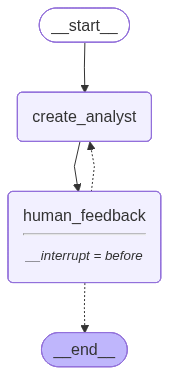

In [47]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [48]:
### Topic
topic = "the benifts of adopting Langgraph as an agent Framework"

### Max analyst
max_analysts = 4 

###Thread id 
thread =  {"configurable":{"thread_id":1}}

### loop it
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in organizations. Her analysis often includes case studies and data-driven insights to demonstrate the tangible benefits of technology adoption.
--------------------------------------------------
Name: Raj Patel
Affiliation: AI Research Lab
Role: AI Framework Analyst
Description: Raj Patel specializes in evaluating AI frameworks and their impact on development workflows. He is keen on understanding how Langgraph as an agent framework can enhance AI model deployment and integration. Raj's work often involves comparing Langgraph with other frameworks to highlight its unique advantages.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Martinez Consulting Group
Role: Bu

In [49]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'the benifts of adopting Langgraph as an agent Framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='Technology Adoption Specialist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in organizations. Her analysis often includes case studies and data-driven insights to demonstrate the tangible benefits of technology adoption.'), Analyst(name='Raj Patel', role='AI Framework Analyst', affiliation='AI Research Lab', description="Raj Patel specializes in evaluating AI frameworks and their impact on development workflows. He is keen on understanding how Langgraph as an agent framework can enhance AI model deployment and integration. Raj's work often involves comparing Langgraph with other frameworks to highlight its unique advantages."), Analyst(name='S

In [50]:
state.next #cursor is at human feedback step

('human_feedback',)

In [51]:
state.values

{'topic': 'the benifts of adopting Langgraph as an agent Framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='Technology Adoption Specialist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in organizations. Her analysis often includes case studies and data-driven insights to demonstrate the tangible benefits of technology adoption.'),
  Analyst(name='Raj Patel', role='AI Framework Analyst', affiliation='AI Research Lab', description="Raj Patel specializes in evaluating AI frameworks and their impact on development workflows. He is keen on understanding how Langgraph as an agent framework can enhance AI model deployment and integration. Raj's work often involves comparing Langgraph with other frameworks to highlight its unique advantages."),
  Analyst(name='Sophia Martinez'

In [52]:
# memory.storage
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0adc05-0768-6ab9-bfff-0ee6250d3473': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-20T14:23:14.375744+00:00\xa2id\xd9$1f0adc05-0768-6ab9-bfff-0ee6250d3473\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.4235131643242567\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0adc05-076b-6a5f-8000-33908ed06d97': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-20T14:23:14.376955+00:00\xa2id\xd9$1f0adc05-076b-6a5f-8000-33908ed06d97\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.43571911835957866\xa5topic\xd9400000000000000000000000000000002.0.43571911835957866\xacmax_analysts\xd9400000000000000000000000000000002.0.43571911835957866\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.43571911835957866\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start_

In [53]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0adc05-5872-6a1a-8001-2134c51ce514'}}

In [54]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},
                   as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0adc05-5949-60f6-8002-b1fa30f58362'}}